# Using global differential privacy with pytorch  in a model that predicts house prices with multiple linear regression.

Using a database from kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview we are going to practice creating a regression model and then applying differential privacy techniques but getting accurate enough results
Libraries: Pandas, numpy, pytorch and scikit-learn.
Steps:
#### 1. Use train dataset as private and partition it for PATE
#### 2. Pick what you think would be some relevant variables to work
#### 3. Create a number of teacher-regression models and then the aggregated teacher.
#### 4. Train a student model with the test data
#### 5. Calculate accuracy
#### 6. Play with another variables, to see improvements of the accuracy 

In [1]:
# Importing libraries
import pandas as pd
import numpy
import torch
import matplotlib.pyplot as plt
# Importing linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

In [2]:
# Label encoder to transform no numeric results of variables into numeric
def colTransform(df, col, cats):
    enc = LabelEncoder()
    enc.fit(cats)
    return enc.transform(df[col])

In [3]:
# Loading training and test dataset
train_data=pd.DataFrame(pd.read_csv('train.csv', engine='python'))
# Preview of the train dataset
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Preview of the dataset variable types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# Transforming the no numeric data in train_data
train_data['Utilities'] = colTransform(train_data, 'Utilities', ['NA', 'ELO', 'NoSeWa', 'NoSewr', 'AllPub'])
train_data['CentralAir'] = colTransform(train_data, 'CentralAir', ['N', 'Y'])
train_data['HeatingQC'] = colTransform(train_data, 'HeatingQC', ['NA', 'Po', 'Fa', 'TA','Gd','Ex'])
train_data['ExterQual'] = colTransform(train_data, 'ExterQual', ['Po', 'Fa', 'TA','Gd','Ex'])
train_data['ExterCond'] = colTransform(train_data, 'ExterCond', ['Po', 'Fa', 'TA','Gd','Ex'])
train_data['KitchenQual'] = colTransform(train_data, 'KitchenQual', ['NA', 'Po', 'Fa', 'TA','Gd','Ex'])
train_data['PavedDrive'] = colTransform(train_data, 'PavedDrive', ['N', 'P', 'Y'])
train_data['Functional'] = colTransform(train_data, 'Functional', ['NA', 'Sal', 'Sev', 'Maj2','Maj1', 'Mod', 'Min2', 'Min1', 'Typ'])
train_data = train_data.replace(numpy.nan, 'null', regex=True)
train_data['Alley'] = colTransform(train_data, 'Alley', ['null', 'Grvl', 'Pave', 'NA' ])
train_data['Fence'] = colTransform(train_data, 'Fence', ['null','GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'])
train_data['BsmtFinType1'] = colTransform(train_data, 'BsmtFinType1', ['null', 'NA', 'Unf', 'LwQ', 'Rec','BLQ','ALQ', 'GLQ'])
train_data['MasVnrType'] = colTransform(train_data, 'MasVnrType', ['null', 'BrkCmn', 'BrkFace', 'CBlock','None','Stone'])
train_data['BsmtExposure'] = colTransform(train_data, 'BsmtExposure', ['null', 'Gd', 'Av', 'Mn', 'No', 'NA'])

In [6]:
# Total area
train_data['TotArea']=train_data['1stFlrSF']+train_data['2ndFlrSF']+train_data['GarageArea']+train_data['TotRmsAbvGrd']
train_data['log_YearRemodAdd']=train_data['YearRemodAdd'].apply(numpy.log)
train_data['log_YearBuilt']=train_data['YearBuilt'].apply(numpy.log)
train_data['log_GrLivArea']=train_data['GrLivArea'].apply(numpy.log)
train_data['log_1stFlrSF']=train_data['1stFlrSF'].apply(numpy.log)
# Selecting the variables that we are going to use in our model
x = train_data[['OverallQual','log_1stFlrSF','TotArea','log_GrLivArea','GarageCars','FullBath','log_YearBuilt','log_YearRemodAdd','Utilities','HeatingQC','KitchenQual','Alley','Fence','BsmtFinType1','MasVnrType','BsmtExposure']]
# Y: Sale price
y = train_data[['SalePrice']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)
# Adding features
poly=PolynomialFeatures(interaction_only=True)
x_train=poly.fit_transform(x_train)
x_test=poly.transform(x_test)
# To normalize
normalizer=StandardScaler()
x_train=normalizer.fit_transform(x_train)
x_test=normalizer.transform(x_test)

In [7]:
# Code for linear regression model
mlr = LinearRegression(normalize=True)
mlr.fit(x_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [8]:
# Prediction with all test values
print("Test score:")
print(mlr.score(x_test, y_test))

Test score:
0.798773221248487


In [9]:
# To show how .score calculates the accuracy
y_predict=mlr.predict(x_test)
u=((y_test - y_predict) ** 2).sum()
v=((y_test - y_test.mean()) ** 2).sum()
r_squared=1-(u/v)
r_squared

SalePrice    0.798773
dtype: float64

In [10]:
# Prediction with all training values
print("Training score:")
print(mlr.score(x_train,y_train))

Training score:
0.8952956482350141


In [16]:
# Calculate the rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_test = sqrt(mean_squared_error(y_test, y_predict))
print("rmse for test:", rmse_test)

rmse for test: 39152.77263910261


In [23]:
# Printing the coefficients of the function
print(mlr.coef_)

[[-1.45456790e-05 -6.01077783e+05  6.21189874e+05  4.57284105e+06
  -1.98371373e+06 -2.43036523e+06 -2.98301220e+06  4.38028530e+05
  -1.87120867e+04 -6.66418691e+01  2.23017206e+06 -3.45080001e+05
   1.93963760e+06  1.26409849e+06  4.36640086e+05 -2.48657733e+05
  -4.97320546e+05  1.14810674e+05  1.20085451e+05 -1.18838691e+05
  -1.40918372e+04 -7.23989847e+03 -2.59250727e+06  3.12895243e+06
  -6.66418694e+01 -1.89022661e+03  8.21144605e+03  1.35590735e+04
   1.10430657e+04 -8.07175883e+03 -2.45777726e+03  3.46610524e+04
  -6.05770017e+05  8.69357606e+05  1.69607744e+05 -9.61261855e+04
  -5.76390253e+05 -4.65213260e+05 -6.66418701e+01 -9.01570366e+03
   4.16009829e+04 -8.52259187e+04  2.35033809e+03 -9.29174945e+04
  -9.85148806e+02 -1.43410059e+04 -1.66009530e+05  2.71163628e+04
   1.89753543e+05  6.18876137e+06 -1.02333654e+07 -6.66418694e+01
   1.08080184e+04  1.26990304e+04  6.37669771e+04 -1.46503711e+04
  -1.63532631e+04 -1.83451109e+04 -4.10538205e+04 -1.59622118e+04
  -4.52669

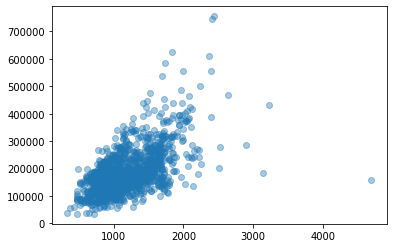

In [11]:
plt.scatter(train_data[['1stFlrSF']], train_data[['SalePrice']], alpha=0.4)

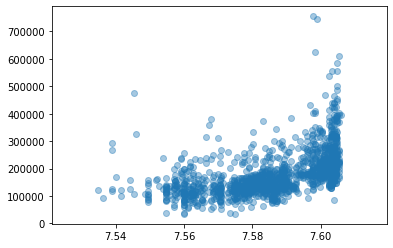

In [12]:
plt.scatter(train_data[['log_YearBuilt']], train_data[['SalePrice']], alpha=0.4)

In [13]:
# Printing correlation matrix
corr_matrix=train_data.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice           1.000000
OverallQual         0.790982
TotArea             0.778212
GrLivArea           0.708624
log_GrLivArea       0.695118
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
log_1stFlrSF        0.591264
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
log_YearBuilt       0.520574
YearRemodAdd        0.507101
log_YearRemodAdd    0.506848
Fireplaces          0.466929
BsmtFinSF1          0.386420
WoodDeckSF          0.324413
2ndFlrSF            0.319334
OpenPorchSF         0.315856
HalfBath            0.284108
LotArea             0.263843
CentralAir          0.251328
PavedDrive          0.231357
BsmtFullBath        0.227122
BsmtUnfSF           0.214479
BedroomAbvGr        0.168213
Fence               0.150933
Alley               0.142507
ExterCond           0.117303
Functional          0.116706
ScreenPorch         0.111447
PoolArea            0.092404
MoSold        

<function matplotlib.pyplot.show(*args, **kw)>

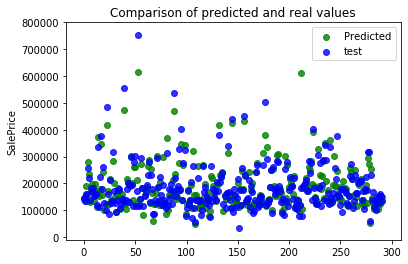

In [20]:
id=range(0,len(y_predict),1)
plt.scatter(id, y_predict, color='green',marker="o",alpha=0.8) 
plt.scatter(id, y_test, color='blue',marker="o",alpha=0.8)
plt.ylabel('SalePrice')
plt.title('Comparison of predicted and real values')
plt.legend(['Predicted', 'test'])
plt.show

In [21]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
OverallQual         1460 non-null int64
log_1stFlrSF        1460 non-null float64
TotArea             1460 non-null int64
log_GrLivArea       1460 non-null float64
GarageCars          1460 non-null int64
FullBath            1460 non-null int64
log_YearBuilt       1460 non-null float64
log_YearRemodAdd    1460 non-null float64
Utilities           1460 non-null int32
HeatingQC           1460 non-null int32
KitchenQual         1460 non-null int32
Alley               1460 non-null int32
Fence               1460 non-null int32
BsmtFinType1        1460 non-null int32
MasVnrType          1460 non-null int32
BsmtExposure        1460 non-null int32
dtypes: float64(4), int32(8), int64(4)
memory usage: 137.0 KB
